Author: William Staal

Date: 8/07/2024

Description: 

This script trains an XGBoost model to predict CNC tool life based on input features. 
The data includes various parameters affecting tool life, and the goal is to build 
a predictive model to estimate the remaining life of CNC tools.

Usage:
python train_xgboost_tool_life.ipynb

Requirements:
- Python 3.7+
- pandas
- numpy
- scikit-learn
- xgboost
- matplotlib (optional, for visualization)
- seaborn (optional, for visualization)

Sections:

1. Import Libraries
2. Load and Preprocess Data
3. Feature Engineering
4. Train-Test Split
5. Model Training
6. Model Evaluation
7. Hyperparameter Tuning (optional)
8. Save Model
9. Conclusion


In [2]:
import xgboost as xgb
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import pandas for data manipulation
import seaborn as sns  # Import seaborn for data visualization
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # Import Decision Tree and export function
from sklearn.model_selection import train_test_split  # Import train_test_split for splitting data
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder for encoding categorical data
from sklearn import preprocessing  # Import preprocessing for data preprocessing
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score  # Import metrics for evaluating models
import warnings  # Import warnings to handle warnings
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
%matplotlib inline

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore future warnings

In [4]:
frames = list()  # Initialize an empty list to store data frames
#results = pd.read_csv('train.csv')  # Read the main results CSV file
results = pd.read_csv("F:/Msc Project/Python/train.csv")  # Read the main results CSV file

In [5]:
for i in range(1, 19):  # Loop through each experiment CSV file
    exp = '0' + str(i) if i < 10 else str(i)  # Format the experiment number to ensure two digits
    #frame = pd.read_csv('experiment_{}.csv'.format(exp))  # Read the experiment CSV file
    frame = pd.read_csv("F:/Msc Project/Python/experiment_{}.csv".format(exp))  # Read the experiment CSV file
    row = results[results['No'] == i]  # Find the corresponding row in the results DataFrame
    frame['target'] = 1 if row.iloc[0]['passed_visual_inspection'] == 'no' else 0  # Add a target column based on tool condition
    frames.append(frame)  # Append the data frame to the list of frames

df = pd.concat(frames, ignore_index=True)  # Concatenate all the experiment data frames into one DataFrame


: 

Data Preprocessing through numeric conversion

In [6]:
df = df.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric, coercing errors to NaN
df_correlation = df.corr()  # Calculate the correlation matrix for the DataFrame

The last 4 variables contain exit interview information and should not be used for prediction and so we remove them.

In [7]:
df_correlation.drop(columns=['Z1_CurrentFeedback', 'Z1_DCBusVoltage', 'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_SystemInertia', 'target'], inplace=True)  # Drop specified columns from the correlation matrix

Before training we are able to visualise a heatmap to show the correlation matrix

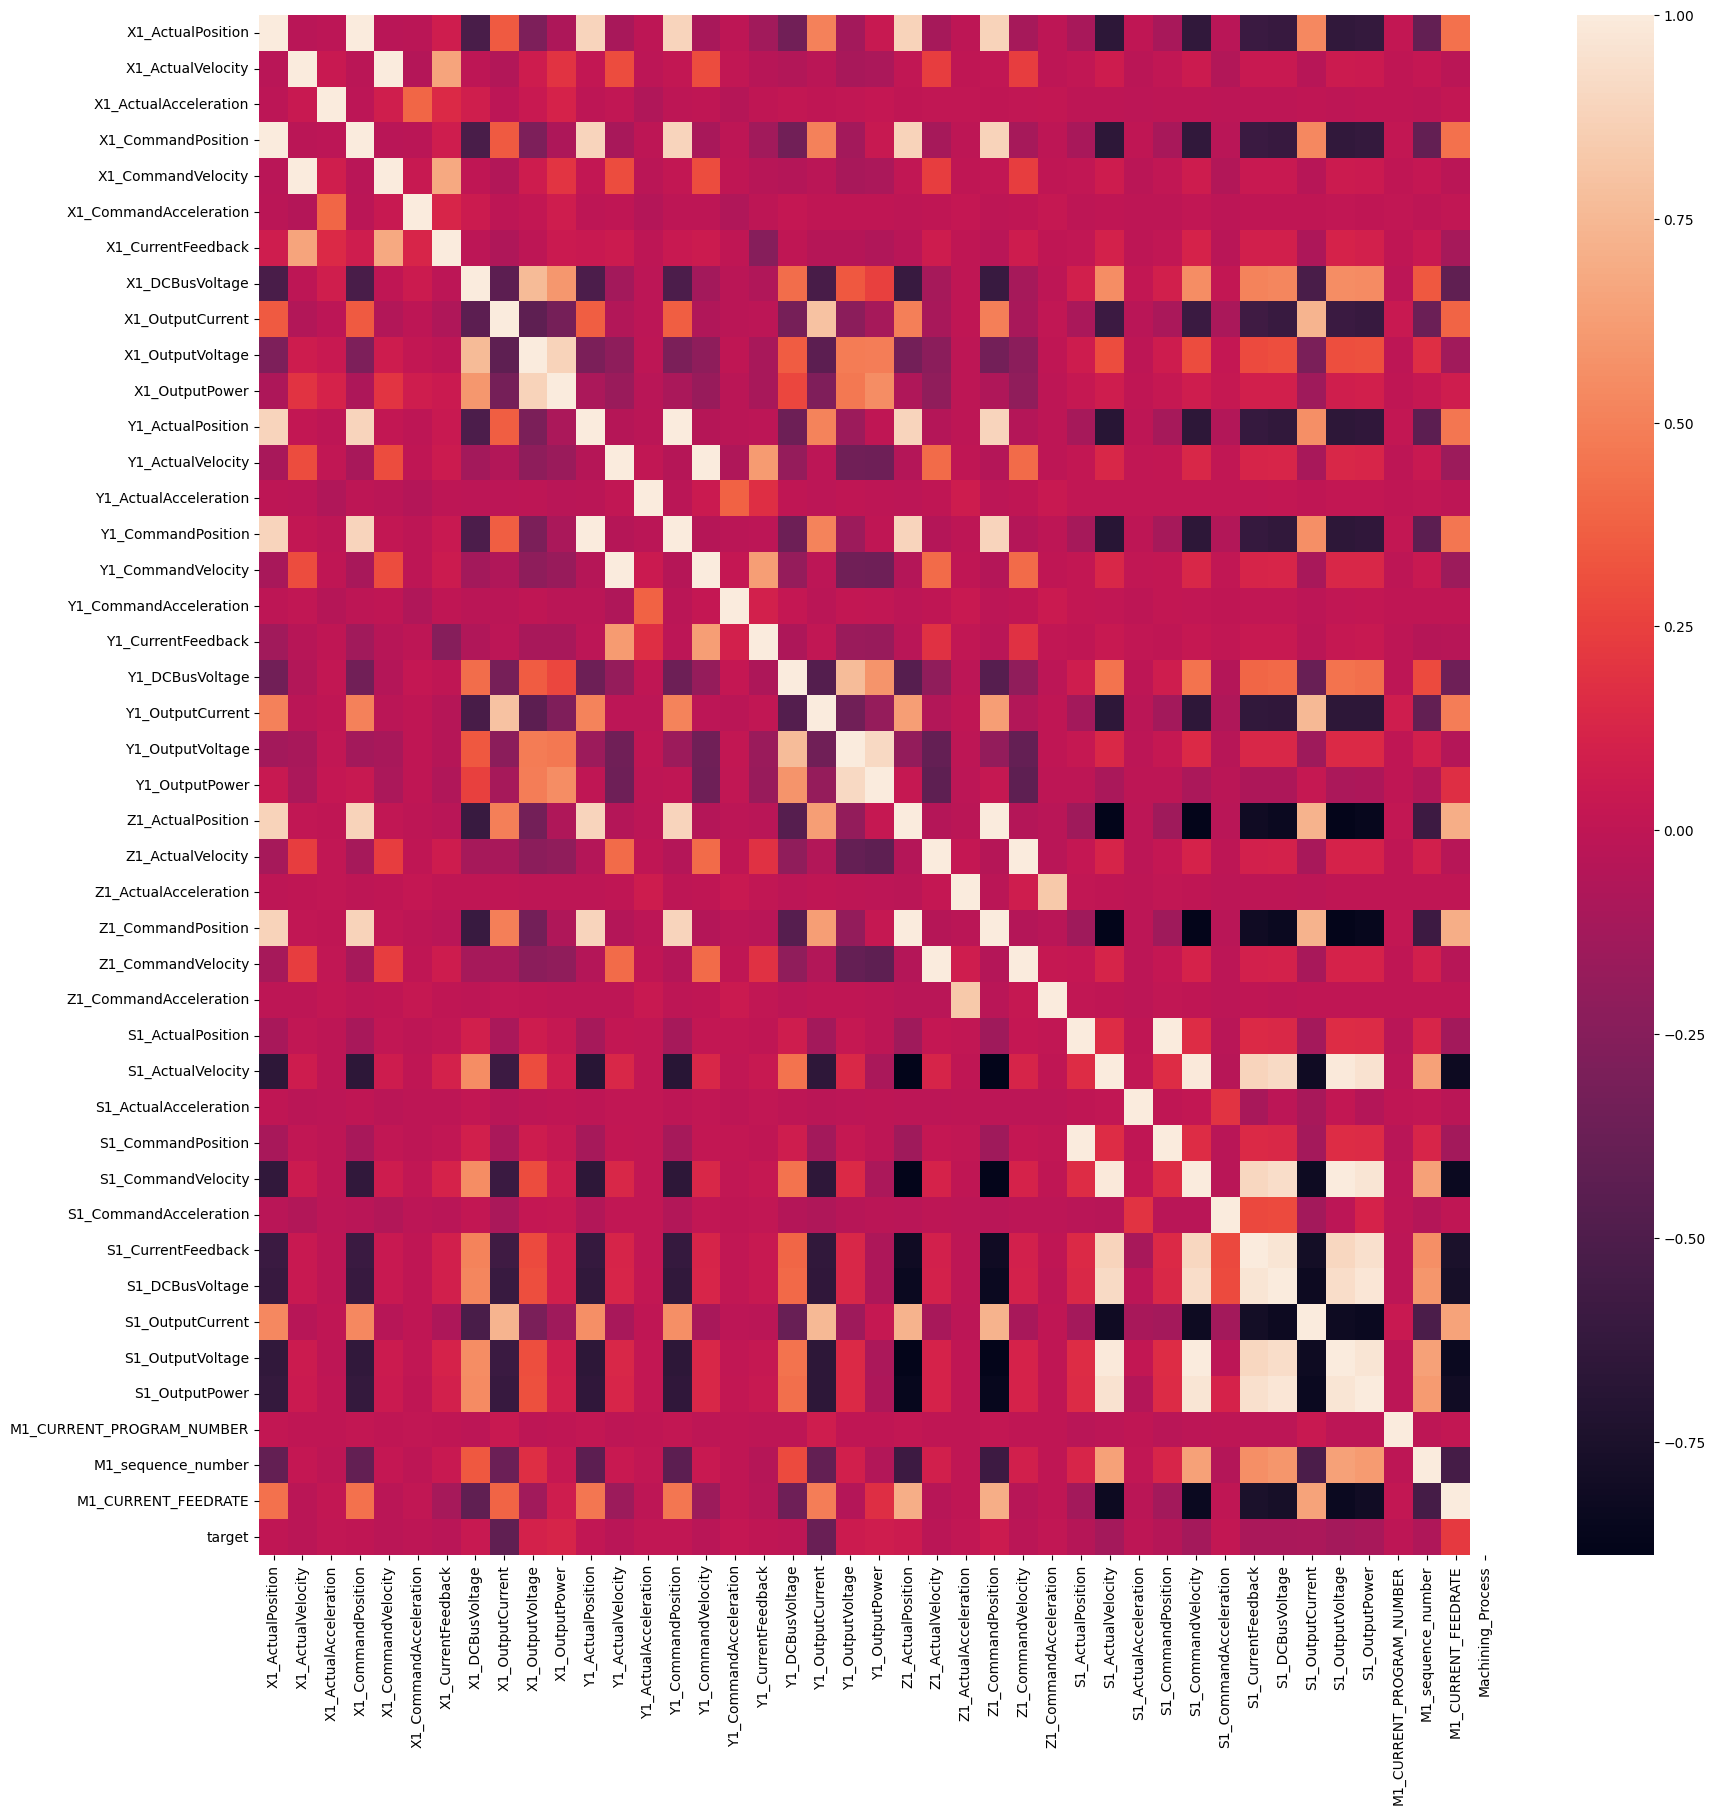

In [8]:
plt.figure(figsize=(20,20))  # Set the size of the plot
df_correlation.dropna(thresh=1,inplace=True)
sns.heatmap(df_correlation, annot=False)  # Create a heatmap of the correlation matrix without annotations
plt.show()  # Display the plot

We have removed any unhelpful data and reformatted collumn names and data within collumns to be able to build a tree, next is dealing with Missing Data

Lets see what each sort of data is in each column

In [9]:
df.dtypes

X1_ActualPosition            float64
X1_ActualVelocity            float64
X1_ActualAcceleration        float64
X1_CommandPosition           float64
X1_CommandVelocity           float64
X1_CommandAcceleration       float64
X1_CurrentFeedback           float64
X1_DCBusVoltage              float64
X1_OutputCurrent             float64
X1_OutputVoltage             float64
X1_OutputPower               float64
Y1_ActualPosition            float64
Y1_ActualVelocity            float64
Y1_ActualAcceleration        float64
Y1_CommandPosition           float64
Y1_CommandVelocity           float64
Y1_CommandAcceleration       float64
Y1_CurrentFeedback           float64
Y1_DCBusVoltage              float64
Y1_OutputCurrent             float64
Y1_OutputVoltage             float64
Y1_OutputPower               float64
Z1_ActualPosition            float64
Z1_ActualVelocity            float64
Z1_ActualAcceleration        float64
Z1_CommandPosition           float64
Z1_CommandVelocity           float64
Z

A lot of columns are float64, and this is OK, because, as we saw when we ran head() there were a lot of numeric values from the machine responses, however lets verify that we are getting what we expect

In [10]:
df['target'].unique()

array([0, 1], dtype=int64)

Now we've handled the missing data, we can start formatting the data for making the XGBoost model:

1. The collumns of data we will use to make classifications
2. The column of data that we want to predict(in this case target value)

In [11]:
X = df.drop('target', axis=1).copy()
X.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,...,0.524,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,NaN
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,...,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,NaN
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,...,0.524,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,NaN
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,...,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,NaN
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,...,0.226,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,NaN


In [12]:
y = df['target'].copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [13]:
x=df.drop(columns=['target','Machining_Process'],axis=1)
y=np.array(df['target'])
X_train,X_test,y_train,y_test =train_test_split(x,y,train_size=0.8,random_state=100)

Checking Stratify techniques will be needed:

In [14]:
sum(y_train)/len(y_train)

0.15488431876606684

In [15]:
sum(y_test)/len(y_test)

0.15994464215104784

As in this case both y_train and y_test have the same percentages, Stratify is unnecessary and we can now build a preliminary model

In [16]:
# Initialize and fit the model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train,
              early_stopping_rounds=10,
              eval_metric='aucpr',
              eval_set=[(X_test, y_test)],
              verbose=True)

[0]	validation_0-aucpr:0.94641
[1]	validation_0-aucpr:0.97980
[2]	validation_0-aucpr:0.98886
[3]	validation_0-aucpr:0.99214
[4]	validation_0-aucpr:0.99308
[5]	validation_0-aucpr:0.99407
[6]	validation_0-aucpr:0.99450
[7]	validation_0-aucpr:0.99468
[8]	validation_0-aucpr:0.99595
[9]	validation_0-aucpr:0.99583
[10]	validation_0-aucpr:0.99584
[11]	validation_0-aucpr:0.99679
[12]	validation_0-aucpr:0.99719
[13]	validation_0-aucpr:0.99780
[14]	validation_0-aucpr:0.99801
[15]	validation_0-aucpr:0.99797
[16]	validation_0-aucpr:0.99808
[17]	validation_0-aucpr:0.99797
[18]	validation_0-aucpr:0.99849
[19]	validation_0-aucpr:0.99892
[20]	validation_0-aucpr:0.99916
[21]	validation_0-aucpr:0.99908
[22]	validation_0-aucpr:0.99933
[23]	validation_0-aucpr:0.99941
[24]	validation_0-aucpr:0.99956
[25]	validation_0-aucpr:0.99960


C:\Users\Wstaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Wstaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-aucpr:0.99959
[27]	validation_0-aucpr:0.99967
[28]	validation_0-aucpr:0.99964
[29]	validation_0-aucpr:0.99972
[30]	validation_0-aucpr:0.99974
[31]	validation_0-aucpr:0.99976
[32]	validation_0-aucpr:0.99980
[33]	validation_0-aucpr:0.99980
[34]	validation_0-aucpr:0.99979
[35]	validation_0-aucpr:0.99981
[36]	validation_0-aucpr:0.99984
[37]	validation_0-aucpr:0.99984
[38]	validation_0-aucpr:0.99985
[39]	validation_0-aucpr:0.99987
[40]	validation_0-aucpr:0.99988
[41]	validation_0-aucpr:0.99988
[42]	validation_0-aucpr:0.99989
[43]	validation_0-aucpr:0.99991
[44]	validation_0-aucpr:0.99991
[45]	validation_0-aucpr:0.99991
[46]	validation_0-aucpr:0.99992
[47]	validation_0-aucpr:0.99992
[48]	validation_0-aucpr:0.99993
[49]	validation_0-aucpr:0.99992
[50]	validation_0-aucpr:0.99993
[51]	validation_0-aucpr:0.99993
[52]	validation_0-aucpr:0.99994
[53]	validation_0-aucpr:0.99994
[54]	validation_0-aucpr:0.99994
[55]	validation_0-aucpr:0.99993
[56]	validation_0-aucpr:0.99993
[57]	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Okay so, we've built an XGBoost Model for classification. Lets see how it performs on the testing dataset by running the testing dataset down the model and drawing a confusion matrix

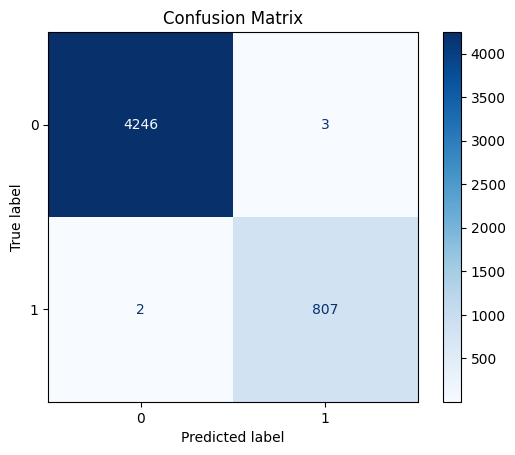

In [17]:
# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Considering how accurate the system already is, Optimisation Will Likely Be Unnecessary

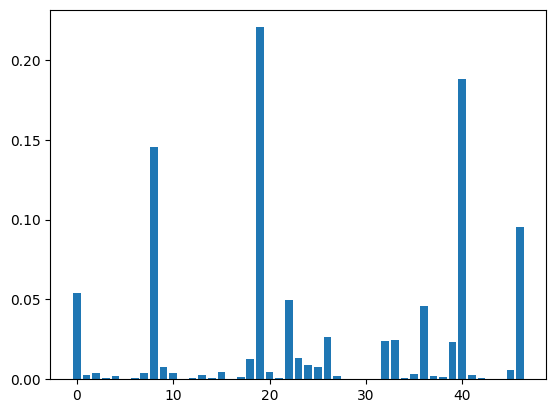

In [19]:
#Plot feature importances
# Plot the feature importances
plt.bar(range(len(xgb_model.feature_importances_)),xgb_model.feature_importances_)
plt.show()

In [20]:
# Cell 10: Print top 10 features
# Get and sort feature importances
features = [(x.columns[i], v) for i, v in enumerate(xgb_model.feature_importances_)]
features.sort(key=lambda x: x[1], reverse=True)
# Print top 10 features
for item in features[:10]:
    print("{0}: {1:0.4f}".format(item[0], item[1]))

Y1_OutputCurrent: 0.2204
S1_OutputCurrent: 0.1878
X1_OutputCurrent: 0.1454
M1_CURRENT_FEEDRATE: 0.0951
X1_ActualPosition: 0.0541
Z1_ActualPosition: 0.0497
S1_CommandVelocity: 0.0457
Z1_CommandVelocity: 0.0267
S1_ActualVelocity: 0.0249
S1_ActualPosition: 0.0238


We can see that the optimised XGBoost model is a lot better at identifiying if Tool Wear has occured. However this improvement was at the expense of not being able to correctly classify as many Anomalous results where the tool isn't worn but may be listed as worn. With this said This trade off may be better for the manufacturer because now it can focus resources on ensuring less on recovery operations for when a tool breaks, and more for slight inconviences of a healthy tool very occasionally flagging itself as worn, thus saving the manufacturer more time and money overall.

The last step is to draw the first XGBoost Tree and discuss how to interpret it

weight:  {'X1_DCBusVoltage': 1.0, 'S1_OutputCurrent': 2.0, 'M1_CURRENT_FEEDRATE': 2.0}
gain:  {'X1_DCBusVoltage': 798.4228515625, 'S1_OutputCurrent': 2865.607421875, 'M1_CURRENT_FEEDRATE': 4347.2041015625}
cover:  {'X1_DCBusVoltage': 1791.9920654296875, 'S1_OutputCurrent': 2293.24365234375, 'M1_CURRENT_FEEDRATE': 4165.05859375}
total_gain:  {'X1_DCBusVoltage': 798.4228515625, 'S1_OutputCurrent': 5731.21484375, 'M1_CURRENT_FEEDRATE': 8694.408203125}
total_cover:  {'X1_DCBusVoltage': 1791.9920654296875, 'S1_OutputCurrent': 4586.4873046875, 'M1_CURRENT_FEEDRATE': 8330.1171875}


C:\Users\Wstaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:160: UserWarning: [13:16:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "learn_rate", "reg_lamda" } are not used.

  warnings.warn(smsg, UserWarning)


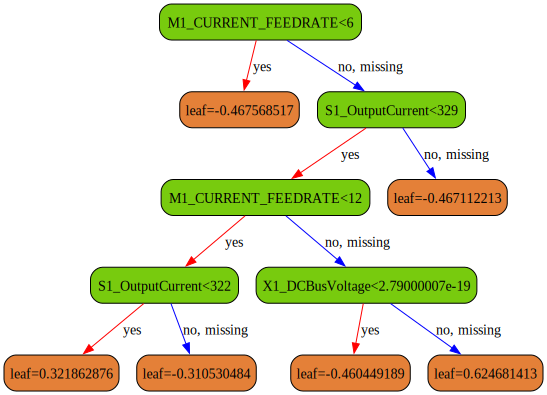

In [21]:
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective='binary:logistic',
                            gamma=0.25,
                            learn_rate=0.5,
                            max_depth=4,
                            reg_lamda=10,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            n_estimators=1) #we set this to 1 so we plot only one tree
clf_xgb.fit(X_train, y_train,)

bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', ##make the nodes fancy
               'style': 'filled, rounded',
                'fillcolor':'#78cbe' }
leaf_params = {'shape': 'box', ##make the nodes fancy
               'style': 'filled, rounded',
                'fillcolor':'#e48038' }

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)


The values at the leaf nodes in a decision tree generated by an XGBoost classifier represent the prediction scores (logits) for those leaves. In the context of a binary classification problem using the 'binary:logistic' objective, these scores are used to compute the predicted probability of the positive class.

Here's a breakdown of what these leaf values mean:

1. **Logits**: The leaf values are raw prediction scores, often referred to as logits. In the context of 'binary:logistic', these values are passed through the logistic function (sigmoid function) to obtain a probability value between 0 and 1.

2. **Probability Calculation**: The predicted probability of the positive class is calculated as:
   \[ P(\text{positive class}) = \frac{1}{1 + \exp(-\text{logit})} \]
   where the logit is the leaf value. For example, if a leaf has a value of \( -1.17591691 \), the probability of the positive class would be:
   \[ P(\text{positive class}) = \frac{1}{1 + \exp(-(-1.17591691))} \approx 0.2357 \]

3. **Interpretation**:
   - **Negative Values**: Leaf values less than zero indicate that the model predicts a low probability for the positive class, i.e., the model leans towards predicting the negative class.
   - **Positive Values**: Leaf values greater than zero indicate that the model predicts a higher probability for the positive class.


1. **Tree Traversal**: When the model is predicting whether a tool is worn, it takes an input feature vector (e.g., measurements or characteristics of the tool). The model then traverses the decision tree(s) based on the feature values, following the decision rules (splits) at each node until it reaches a leaf node.

2. **Leaf Value (Logit)**: The leaf node reached contains a value called the logit. This value is a raw score that indicates the confidence level of the model's prediction for the positive class (in this case, 'worn').

3. **Probability Calculation**: The logit is converted into a probability using the sigmoid function:
   \[ P(\text{worn}) = \frac{1}{1 + \exp(-\text{logit})} \]

   For example, if a leaf node has a value of -1.17591691, the probability of the tool being worn is calculated as:
   \[ P(\text{worn}) = \frac{1}{1 + \exp(1.17591691)} \approx 0.2357 \]

4. **Decision Threshold**: A threshold (usually 0.5) is applied to the probability to make the final classification:
   - **If \( P(\text{worn}) \geq 0.5 \), the model predicts that the tool is worn (1).**
   - **If \( P(\text{worn}) < 0.5 \), the model predicts that the tool is not worn (0).**

**How This Helps Classify**:
- **High Logit Values**: If the feature vector for a tool leads to a leaf with a high positive value, the corresponding probability will be high, indicating a high likelihood that the tool is worn.
- **Low Logit Values**: Conversely, if the logit value is low or negative, the probability will be low, indicating that the tool is likely not worn.

Thus, the model's prediction is determined by the logit value at the leaf node, which reflects the combined contribution of all the decision rules (splits) applied during the traversal of the tree. The process is repeated for all trees in the model (since XGBoost is an ensemble of trees), and the final prediction is typically based on the average probability from all trees.